# Test the flow of image corrections implemented in the NeaImager module

## Import modules needed

In [16]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import NeaImager as neaim
import os
import copy

## Read a measurement and info file

Attributes: {'filename': 'c:\\Users\\NEMETHG\\OneDrive\\Python\\NeaReader\\testPsHetImage.gwy', 'channel_name': 'O3P raw', 'xreal': 4.9999999999999996e-06, 'yreal': 4.9999999999999996e-06, 'xoff': 4.739293422913177e-05, 'yoff': 4.725213880710662e-05, 'xres': 200, 'yres': 200, 'isamp': False, 'data': array([[-0.8333236 , -0.84125137, -0.84860265, ..., -0.81968194,
        -0.80257469, -0.78750002],
       [-0.86227149, -0.86725813, -0.82084715, ..., -0.8473953 ,
        -0.84172171, -0.80499893],
       [-0.85738885, -0.85846102, -0.83573496, ..., -0.89141959,
        -0.86800754, -0.84280068],
       ...,
       [-0.72819704, -0.7306664 , -0.72129321, ..., -0.76999664,
        -0.77907741, -0.74486798],
       [-0.75853622, -0.76212132, -0.7535702 , ..., -0.77716035,
        -0.74861985, -0.72447395],
       [-0.73346722, -0.73446751, -0.73839897, ..., -0.796956  ,
        -0.73824263, -0.75908107]]), 'parameters': {'Scan': '2D (PsHet)', 'Project': '2023.06.27. Nadia', 'Description': '

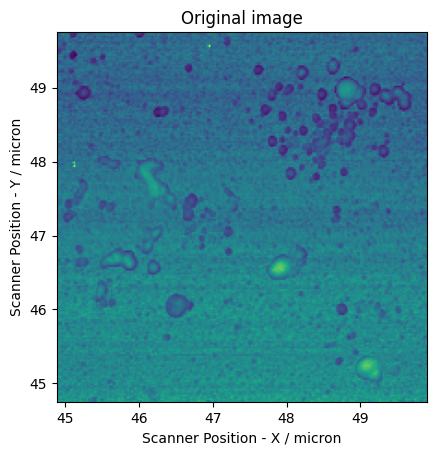

In [17]:
# File path
current_folder = os.getcwd()
meas_path = os.path.join(current_folder,'testPsHetImage.gwy')
info_path = os.path.join(current_folder,'testinfofile.txt')

# Create NeaImage object and load data
channelname = 'O3P raw'
m = neaim.NeaImage()
m.read_from_gwyfile(meas_path,channelname)
m.parameters = m.read_info_file(info_path)

# Print the attributes of neaimage object
print(f'Attributes: {vars(m)}')
print(f'Parameters dict keys: {list(m.parameters.keys())}')

# Plot the original image
xmin = (-m.xreal/2+m.xoff)*1e6
xmax = (m.xreal/2+m.xoff)*1e6
ymin = (-m.yreal/2+m.yoff)*1e6
ymax = (m.yreal/2+m.yoff)*1e6

plt.imshow(m.data, extent=[xmin, xmax, ymin, ymax])
plt.xlabel('Scanner Position - X / micron')
plt.ylabel('Scanner Position - Y / micron')
plt.title('Original image')
plt.show()

## Line leveling

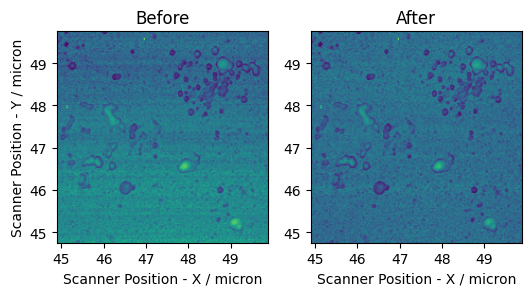

In [18]:
mtype = 'average' # 'difference' or 'median'
m_levelled = neaim.LineLevel(inputobj = m, mtype = mtype)

# Plot before-after
px = 1/plt.rcParams['figure.dpi']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(600*px, 300*px))
# Before image
ax1.imshow(m.data,extent=[xmin, xmax, ymin, ymax])
ax1.set(xlabel='Scanner Position - X / micron',ylabel='Scanner Position - Y / micron')
ax1.set_title('Before')
# After image
ax2.imshow(m_levelled.data,extent=[xmin, xmax, ymin, ymax])
ax2.set(xlabel='Scanner Position - X / micron')
ax2.set_title('After')
plt.show()

## Polynomial background fitting

1. Usecase: Remove plane or more complex backgrounds by 2d fitting
2. Function: Fits and removes a 2d polynomial background
    - polynomial orders are defined by `xorder` and `yorder` arguments
    - returns both backgroung and the corrected image

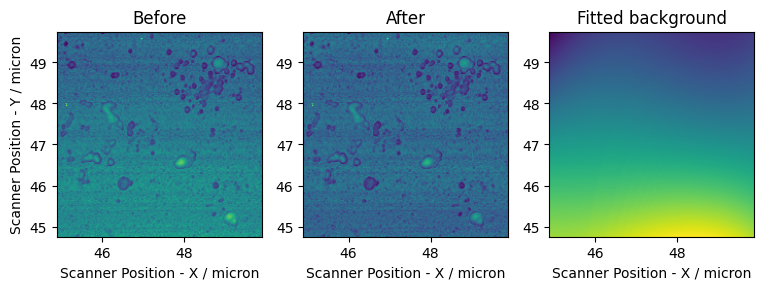

In [19]:
xdegree = 3
ydegree = 2

m_bg, fitted_bg = neaim.BackgroundPolyFit(inputobj = m, xorder=xdegree, yorder=ydegree)

# Plot before-after
px = 1/plt.rcParams['figure.dpi']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(900*px, 300*px))
# Before image
ax1.imshow(m.data,extent=[xmin, xmax, ymin, ymax])
ax1.set(xlabel='Scanner Position - X / micron',ylabel='Scanner Position - Y / micron')
ax1.set_title('Before')
# After image
ax2.imshow(m_bg.data,extent=[xmin, xmax, ymin, ymax])
ax2.set(xlabel='Scanner Position - X / micron')
ax2.set_title('After')
# Fitted background
ax3.imshow(fitted_bg,extent=[xmin, xmax, ymin, ymax])
ax3.set(xlabel='Scanner Position - X / micron')
ax3.set_title('Fitted background')
plt.show()

## Phase rotation

1. Usecase: when you see large jump in the phase images between -pi:pi
2. Function: 
    - loads the amplitude image of the same order
    - creates the complex values image
    - rotates the all complex pixel values with a phase given by the `degree` argument
    - calculates the new phase values

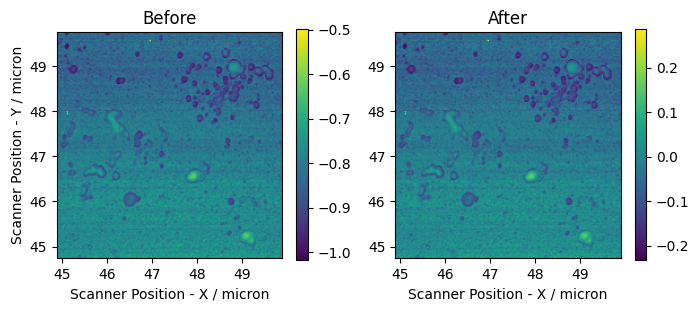

In [20]:
deg = 45
m_rot = neaim.RotatePhase(inputobj = m, degree = deg)

# Plot before-after
px = 1/plt.rcParams['figure.dpi']
imheight = 300*px
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2*imheight + 200*px, imheight))
# Before image
im1 = ax1.imshow(m.data,extent=[xmin, xmax, ymin, ymax])
ax1.set(xlabel='Scanner Position - X / micron',ylabel='Scanner Position - Y / micron')
ax1.set_title('Before')
fig.colorbar(im1,ax=ax1)
# After image
im2 = ax2.imshow(m_rot.data,extent=[xmin, xmax, ymin, ymax])
ax2.set(xlabel='Scanner Position - X / micron')
ax2.set_title('After')
fig.colorbar(im2,ax=ax2)

## Self Referencing
1. Usecase: correct complex artifacts coming from remaining the background scattering not related to near-field interaction
    - Method is based on: L. Mester et al. Nanophotonics 2022; 11(2): 377–390
2. Function: 
    - Loads the given nth order image 
    - Normalizes all the pixel values using the pixels of the loaded image

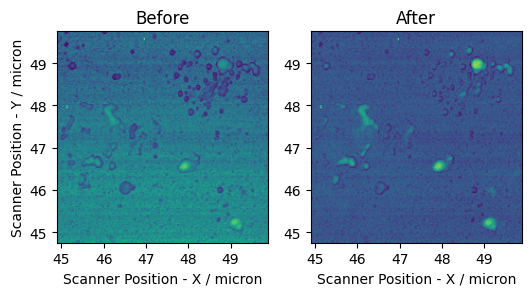

In [21]:
# Define order and call the method
order = 2
m_ref = neaim.SelfReferencing(inputobj = m, order = order)

# Plot before-after
px = 1/plt.rcParams['figure.dpi']
imheight = 300*px
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2*imheight, imheight))
# Before image
ax1.imshow(m.data,extent=[xmin, xmax, ymin, ymax])
ax1.set(xlabel='Scanner Position - X / micron',ylabel='Scanner Position - Y / micron')
ax1.set_title('Before')
# After image
ax2.imshow(m_ref.data,extent=[xmin, xmax, ymin, ymax])
ax2.set(xlabel='Scanner Position - X / micron')
ax2.set_title('After')
plt.show()

## Simple normalization

1. Usecase: simple normalization of all the pixel values with a single number
2. Function: there are two methods
    - `manual`: All the pixels are nomalized with a single value given by the `value` argument
    - `median`: All the pixels are normalized with the median of the image

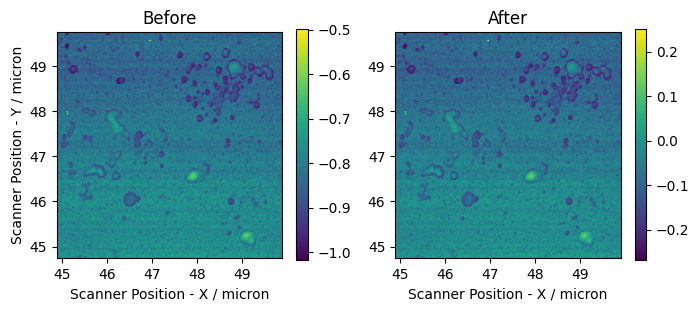

In [14]:
# Choose method
method = 'manual' # OR median, for automatic nromalization with the median of all pixel values
m_norm = neaim.SimpleNormalize(inputobj = m, mtype = method, value = -0.75)

# Plot before-after
px = 1/plt.rcParams['figure.dpi']
imheight = 300*px
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2*imheight + 200*px, imheight))
# Before image
im1 = ax1.imshow(m.data,extent=[xmin, xmax, ymin, ymax])
ax1.set(xlabel='Scanner Position - X / micron',ylabel='Scanner Position - Y / micron')
ax1.set_title('Before')
fig.colorbar(im1,ax=ax1)
# After image
im2 = ax2.imshow(m_norm.data,extent=[xmin, xmax, ymin, ymax])
ax2.set(xlabel='Scanner Position - X / micron')
ax2.set_title('After')
fig.colorbar(im2,ax=ax2)
plt.show()